This notebook processes the CSV file saved by `generic-is-empty.ipynb`.

In [1]:
library(ggplot2)
library(tables)
library(tidyverse)
library(tikzDevice)
options(scipen = 10, width=200)
plain <- function(x,...) format(x, ..., scientific = FALSE, drop0trailing = TRUE)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: Hmisc
Loading required package: lattice
Loading required package: survival
Loading required package: Formula

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, units

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.0.1     ✔ purrr   0.3.0
✔ tidyr   0.8.3     ✔ dplyr   0.7.8
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ tibble  2.0.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::src()       masks Hmisc::src()
✖ dplyr::summarize() masks Hmisc::summarize()


# Load and prepare the data

In [2]:
bench <- read_csv('bench.csv', col_types="iddddfiiiiiiicf")

Warning message:
“Missing column names filled in: 'X1' [1]”

Remove the `Python/`, `C++/`, and `acc/` prefixes in column names.  These were useful in Pandas, but they will clutter our figures and tables.

In [3]:
names(bench)

[1] "X1"               "Python/is_empty1" "Python/is_empty2" "C++/is_empty"     "C++/old_is_empty" "/result"          "aut/states"       "aut/edges"        "aut/sccs"         "aut/ntsccs"      
[11] "aut/nrsccs"       "aut/nrstates"     "aut/sets"         "aut/acc"          "/bench"

In [4]:
names(bench)<- sub("bench", "dataset", sub(".*/", "", names(bench)))

Rename the results to something meaningful.

In [5]:
levels(bench$result)

[1] "FFFF" "TTTT"

In [6]:
levels(bench$result) <- c("non-empty", "empty")

Remove dataset `small`, because the automata are really too small to be interesting, and not discussing them saves space in the paper.

In [7]:
bench <- subset(bench, dataset != "small")

# Plots

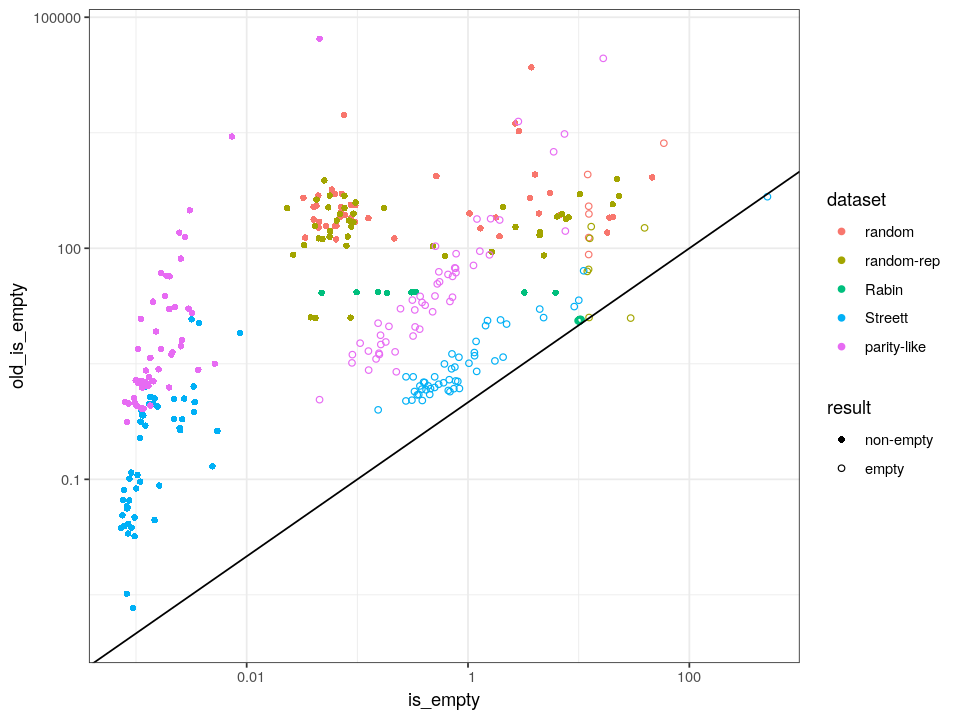

In [8]:
options(repr.plot.width=8, repr.plot.height=6)

ggplot(bench, aes(x=is_empty, y=old_is_empty, colour=dataset, shape=result)) + 
  geom_point() +  geom_abline(slope=1, intercept=0) + scale_shape_manual(values=c(16, 1)) +
  expand_limits(x=0.001, y=0.001) + scale_x_log10(labels=plain) + scale_y_log10(labels=plain) + theme_bw()

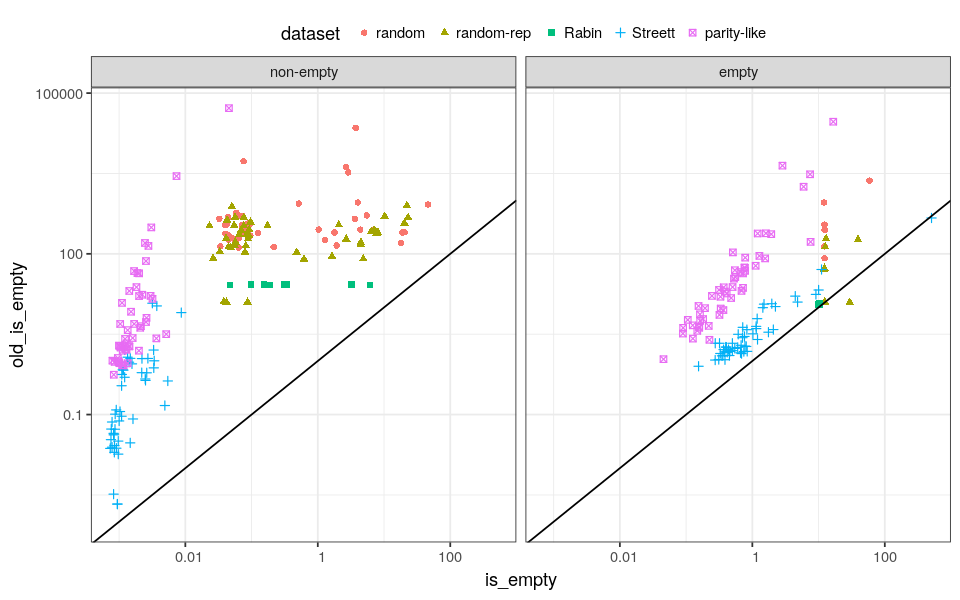

In [9]:
options(repr.plot.width=8, repr.plot.height=5)

g <- guide_legend(nrow=1)
th <- theme(legend.position="top", legend.box.spacing=unit(0, "mm"), legend.text=element_text(margin=margin(l=-7,r=-3)))
p1 <- ggplot(bench, aes(x=is_empty, y=old_is_empty, colour=dataset, shape=dataset)) + 
  geom_point() + geom_abline(slope=1, intercept=0) +
  expand_limits(x=0.001, y=0.001) + scale_x_log10(labels=plain) + scale_y_log10(labels=plain) +
  facet_wrap(~ result) + theme_bw() + th + guides(colour = g, shape=g)
p1

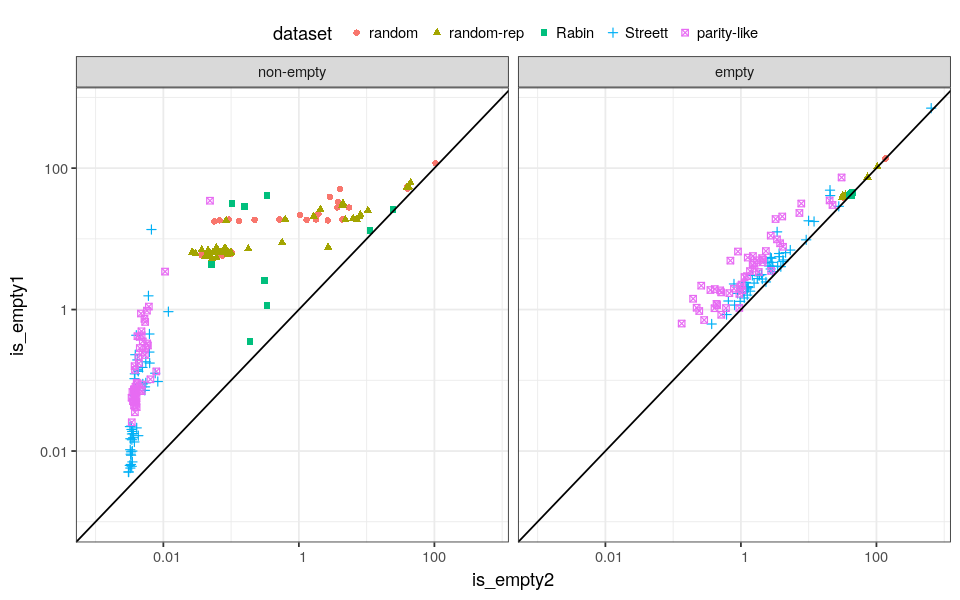

In [10]:
p2 <- ggplot(bench, aes(x=is_empty2, y=is_empty1, colour=dataset, shape=dataset)) + 
  geom_point() + geom_abline(slope=1, intercept=0) +
  expand_limits(x=0.001, y=0.001) + scale_x_log10(labels=plain) + scale_y_log10(labels=plain) +
  facet_wrap(~ result) + theme_bw() + th + guides(colour = g, shape=g)
p2

# Tables

In [11]:
# geometric mean
gmean <- function(x) exp(mean(log(x)))
# arithmetic mean
amean <- mean

The following table shows various statistics about the automata from the benchmarks.

In [12]:
bench <- within(bench, { 
    avgdeg <- edges / states
    nrpercent <- 100 * nrstates / states
    })

In [13]:
tabular(Heading() * result * (dataset + (`(all)`=1)) +  Heading("(all)", nearData=FALSE)*1 ~ 
        DropEmpty() * ((`$n$`=1) + (Heading("st.") * states + 
                                    Heading("deg.") * avgdeg +
                                    Heading("SCCs") * sccs + 
                                    Heading("nt.SCCs") * ntsccs + 
                                    Heading("nr.SCCs") * nrsccs +
                                    Heading("nr.st.") * nrstates + 
                                    Heading("(%)") * nrpercent + 
                                    sets) * Heading() * amean), data=bench) 

                                                                                       
           dataset     $n$ st.      deg.  SCCs     nt.SCCs nr.SCCs nr.st.  (%)    sets 
 non-empty random       44 100000.0 1.254    6.227   1.182   1.136 99994.8  99.99 20.00
           random-rep   43 100000.0 1.254    4.791   1.256   1.233 99996.4 100.00 20.00
           Rabin         9  10000.0 1.011   77.000   1.222   1.222  9924.2  99.24 32.00
           Streett      50    993.2 4.000  194.880  54.380  36.680   817.4  79.62 10.88
           parity-like  50   6677.4 7.605 1647.820 350.020 300.480  5320.0  82.74 12.80
           (all)       196  46803.7 3.564  476.061 103.760  86.592 46407.2  90.36 16.39
 empty     random        6 100000.0 1.254    3.667   1.167   1.000 99996.0 100.00 20.00
           random-rep    7 100000.0 1.255    5.286   1.143   1.143 99995.9 100.00 20.00
           Rabin        41  10000.0 1.011  118.317   1.171   1.171  9882.9  98.83 32.00
           Streett      50  1002

- $n$ is the number of automata in the data set
- `st.` is the average number of states
- `deg.` is the average degree of these states
- `SCCs` is the average number of SCCs in these automata
- `nt.SCCs` is the average number of SCCs that are not trivial
- `nr.SCCs` is the average number of SCCs that cannot be found rejecting by lines 7--12 on the top-most execution of the algorithm  from the paper
- `nr.st` sum the states in the latter SCCs, and average that over all automata
- `(%)` express `nr.st` as a percentage of `st.`.
- `sets` is the average number of acceptance sets

When the automata are empty, the `nr` metrics help understanding how much of the automaton the algorithm has to recurse into.

This first table shows the improvement between the old and the new C++ emptiness checks.

In [14]:
t1 <- tabular(Heading() * result * (dataset + (`(all)`=1)) + Heading("(all)", nearData=FALSE)*1  
            ~ DropEmpty() * ((`$n$`=1) + 
                             (Heading("\\texttt{old_is_empty}") * old_is_empty * Format(digits=1) + 
                              Heading("\\texttt{is_empty}") * is_empty * Format(digits=1)) * (amean + gmean)), 
             data=bench)
t1

                                                                                  
                           \\texttt{old_is_empty}        \\texttt{is_empty}       
           dataset     $n$ amean                  gmean  amean              gmean 
 non-empty random       44 1105.6                  390.1  3.311              0.326
           random-rep   43  254.2                  186.3  2.980              0.306
           Rabin         9   26.7                   26.7  1.208              0.356
           Streett      50    1.0                    0.2  0.002              0.001
           parity-like  50 1124.4                    6.4  0.003              0.002
           (all)       196  592.3                   14.6  1.454              0.021
 empty     random        6  678.8                  364.7 20.032             15.938
           random-rep    7   91.1                   57.1 18.732             16.595
           Rabin        41   11.6                   11.6 10.195             10.194
    

The following horizontal layout is a bit harder to read in the notebook, but could save space in the paper.

In [15]:
t1b <- tabular(Heading() * dataset + (`(all)`=1) 
            ~ DropEmpty() * Heading() * result * 
               ((`$n$`=1) + 
                (Heading("\\texttt{old_is_empty}") * old_is_empty * Format(digits=1) + 
                 Heading("\\texttt{is_empty}") * is_empty * Format(digits=1)) * (amean + gmean)), 
             data=bench)
t1b

                                                                                                                                            
             non-empty                                                         empty                                                        
                       \\texttt{old_is_empty}        \\texttt{is_empty}              \\texttt{old_is_empty}        \\texttt{is_empty}       
             $n$       amean                  gmean  amean              gmean  $n$   amean                  gmean  amean              gmean 
 random       44       1105.6                  390.1  3.311              0.326   6    678.8                  364.7 20.032             15.938
 random-rep   43        254.2                  186.3  2.980              0.306   7     91.1                   57.1 18.732             16.595
 Rabin         9         26.7                   26.7  1.208              0.356  41     11.6                   11.6 10.195             10.194
 Streett     

This second table shows the improvement between the two Python versions.  is_empty1 corresponding to the algorithm as presented in the paper, and is_empty2 corresponding to the more on-the-fly implementation.

In [16]:
t2 <- tabular(Heading() * result * (dataset + (`(all)`=1)) + Heading("(all)", nearData=FALSE)*1
              ~ DropEmpty() * ((`$n$`=1) + (is_empty1 + is_empty2) * Format(digits=1) * (amean + gmean)), 
              data=bench)
t2

                                                            
                           is_empty1        is_empty2       
           dataset     $n$ amean     gmean  amean     gmean 
 non-empty random       44 19.100    13.008  6.092     0.365
           random-rep   43 14.486    10.620  4.398     0.337
           Rabin         9 16.552     7.278  4.120     0.488
           Streett      50  0.397     0.048  0.004     0.004
           parity-like  50  0.974     0.155  0.005     0.005
           (all)       196  8.576     0.937  2.524     0.038
 empty     random        6 55.502    48.283 49.353    40.733
           random-rep    7 53.954    49.950 48.417    43.000
           Rabin        41 42.929    42.923 42.031    42.025
           Streett      50 20.256     4.063 16.699     2.601
           parity-like  50  7.631     3.688  2.992     1.263
           (all)       154 25.098     9.104 21.707     5.457
 (all)                 350 15.846     2.548 10.965     0.339

# Export to LaTeX

In [17]:
tmp <- booktabs()
table_options(titlerule = '\\cmidrule(l)')
tmp <- latex(file="table1.tex", t1)
tmp <- latex(file="table1b.tex", t1b)
tmp <- latex(file="table2.tex", t2)
tikz("plot1.tex", sanitize=TRUE, standAlone=TRUE, width=4.8, height=3)
p1 + labs(x="\\tt is_empty", y="\\tt old_is_empty")
dev.off()

png 
  2